### Visualize the Scattering and Attenuation Effect

In [1]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import polygon, polygon2mask
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt

import os
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import arr_info
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair, 
                       vis_triple)

In [2]:
#If it's a multi-channel image, try to get it in [0,255]
def to_single_channel(I):
    if (len(I.shape) > 2):
        Ig = 0.2989 * I[..., 0] + 0.5870 * I[..., 1] + 0.1140 * I[..., 2]
        I = Ig

        I = I/I.ravel().max()
        I = 255*I
        I = np.round(I)
        I[I>255] = 255
        I = I.copy().astype('uint8')
        return I

In [3]:
def get_destination_points(corners):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
    Args:
        corners: list
    Returns:
        destination_corners: list
        height: int
        width: int
    """

    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
    return destination_corners, h, w

In [4]:
def unwarp(img, src, dst):
    """
    Args:
        img: np.array
        src: list
        dst: list
    Returns:
        un_warped: np.array
    """
    img_c = img.copy()
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, cv2.RANSAC, 3.0)
    un_warped = cv2.warpPerspective(img_c, H, (w, h), flags=cv2.INTER_LINEAR)
    
    return un_warped

In [5]:
def watershed(img):
    img_c = img.copy()
    gray = cv2.cvtColor(img_c,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    markers = cv2.watershed(img_c,markers)
    img_c[markers == -1] = [255,0,0]
    return markers

In [6]:
def atten_effect(img):
    img = plt.imread(img)
    img_c = img.copy()
    markers = watershed(img)
    bottom = np.where(markers==2)[0].max()
    left = np.where(markers==2)[1].min()
    
    # Some threshold values
    vert_thres = 350
    horz_thres = 50
    length = 80
    dist = 330
    
    # Avoid Extracting incorrect ROI
    while markers[bottom-vert_thres, left+horz_thres] == 1:
        left += horz_thres
    left
    
    # Image Deskewing
    bottom = np.where(markers==1)[0].max()
    left = np.where((markers!=1) & (markers!=-1))[1].min()
    top = np.where(markers==2)[0].min()
    right = np.where((markers!=1) & (markers!=-1))[1].max()
    
    corners = []
    tl = [left, top]
    tr = [right, top]
    bl = [left, bottom]
    br = [right, bottom]
    corners.append(tl)
    corners.append(tr)
    corners.append(bl)
    corners.append(br)
    
    dst, h, w = get_destination_points(corners)
    img = unwarp(img, np.float32(corners), np.float32(dst))
    # coord_left = np.array([[bottom, left+horz_thres], [bottom, left+horz_thres+length], 
    #                    [bottom-vert_thres, left+horz_thres+length], 
    #                    [bottom-vert_thres, left+horz_thres]])
    # coord_right = np.array([[bottom, left+horz_thres+dist], [bottom, left+horz_thres+dist+length], 
    #                     [bottom-vert_thres, left+horz_thres+dist+length], 
    #                     [bottom-vert_thres, left+horz_thres+dist]])
    # I_left = img[coord_left[:,0][0]:coord_left[:,0][2], coord_left[:,1][0]:coord_left[:,1][2]]
    # I_right = img[coord_right[:,0][0]:coord_right[:,0][2], coord_right[:,1][0]:coord_right[:,1][2]]
    # rrl, ccl = polygon(coord_left[:,0], coord_left[:,1], shape=img.shape[:2])
    # rrr, ccr = polygon(coord_right[:,0], coord_right[:,1], shape=img.shape[:2])
    # mask_l = np.zeros(img.shape[:2])
    # mask_l[rrl,ccl] = 1
    # mask_r = np.zeros(img.shape[:2])
    # mask_r[rrr, ccr] = 1
    # img = to_single_channel(img)
    # arr_info(img)
    x = []
    x1 = []
    y = []
    y1 = []
    # for i in range(bottom, bottom-vert_thres, -1):
    #     x.append(i)
    #     y.append(np.mean(img[i-1:i, left+horz_thres:left+horz_thres+length]))
    # for i in range(bottom, bottom-vert_thres, -1):
    #     x1.append(i)
    #     y1.append(np.mean(img[i-1:i, left+horz_thres+dist:left+horz_thres+dist+length]))
    # x = np.array(x)
    # x1 = np.array(x1)
    # y = np.array(y)
    # y1 = np.array(y1)
    for i in range(h, h-vert_thres, -1):
        x.append(h-i)
        y.append(np.mean(img[i-1:i, horz_thres:horz_thres+length]))
    for i in range(h, h-vert_thres, -1):
        x1.append(h-i)
        y1.append(np.mean(img[i-1:i, horz_thres+dist:
                                         horz_thres+dist+length]))
    return x1, y1

In [7]:
path1 = '../stacked_new/NTU108.jpg'
path2 = '../stacked_new/NTU123.jpg'
path3 = '../stacked_new/NTU182.jpg'
path5 = '../stacked_new/NTU224.jpg'
path4 = '../stacked_new/NTU341.jpg'
path6 = '../stacked_new/NTU281.jpg'
a1, a2 = atten_effect(path1)
b1, b2 = atten_effect(path2)
c1, c2 = atten_effect(path3)
d1, d2 = atten_effect(path4)
e1, e2 = atten_effect(path5)
f1, f2 = atten_effect(path6)

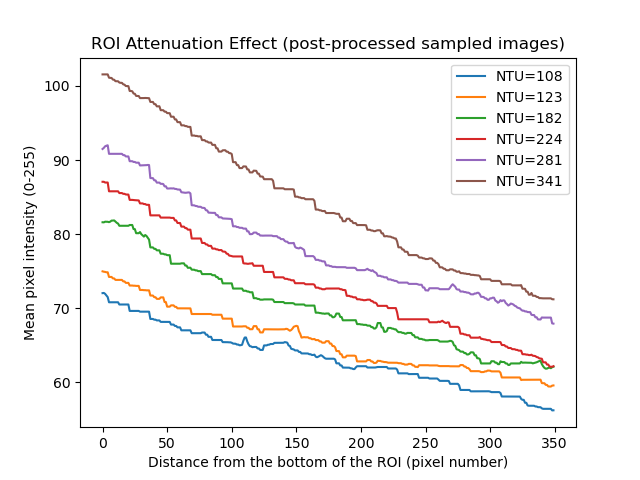

In [8]:
# Figure 7
plt.figure()
plt.plot(a1,a2,label='NTU=108')
plt.plot(b1,b2,label='NTU=123')
plt.plot(c1,c2,label='NTU=182')
plt.plot(e1,e2,label='NTU=224')
plt.plot(f1,f2,label='NTU=281')
plt.plot(d1,d2,label='NTU=341')
plt.title("ROI Attenuation Effect (post-processed sampled images)")
plt.xlabel("Distance from the bottom of the ROI (pixel number)")
plt.ylabel("Mean pixel intensity (0-255)")
plt.legend()
plt.show()

In [9]:
plt.tight_layout()

In [10]:
plt.savefig('../assets/atten_effect.pdf', dpi=600)

In [ ]:
path1 = '../stacked_test/NTU85_8.jpg'   # 33.3, 272, 167
img = plt.imread(path1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

In [ ]:
img = plt.imread('../assets/NTU95/NTU95a.jpg')
arr_info(img)

In [ ]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

In [ ]:
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)

In [ ]:
vis_pair(img, markers)

In [ ]:
plt.savefig('../assets/watershed.pdf', dpi=600)